In [4]:
import sys
import time
import os
import stim
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pymatching
import subprocess
from IPython.display import SVG, display
from pathlib import Path

# import chromobius

sys.path.insert(0, os.path.abspath('/hpc/home/garn195/NWQ-Sim/stabilizer/src'))

import noise_util as ns
import surface_code as sc
importlib.reload(ns)
import tomography_util as tm
importlib.reload(sc)
importlib.reload(ns)
importlib.reload(tm)

<module 'tomography_util' from '/hpc/home/garn195/NWQ-Sim/stabilizer/src/tomography_util.py'>

In [5]:
# Experiment Parameters
SHOTS = 1000000
BASE_ERROR = 0.001
DISTANCES = np.array([11, 9, 5, 3])
T1 = 10 ** -4
T2 = 10 ** -4
tau = np.array([10**-7, 2*10**-7, 5*10**-7, 8*10**-7, 10**-6, 2*10**-6, 5*10**-6, 10**-5])
lam = 1/T2 - 1/(2*T1)
p_amp = 1 - np.exp(-tau/T1)
p_phase = 1 - np.exp(-lam*tau)

# Compile the C++ code once before the loop
print("Compiling C++ simulator (MPI)...")
compile_command = [
    "mpicxx",  # use MPI compiler wrapper
    "-std=c++17",
    "-O3",
    "-DMPI_ENABLED",
    "-o",
    "noisy_code_sim",
    "noisy_code_sim.cpp"
]
try:
    subprocess.run(compile_command, check=True, capture_output=True, text=True)
    print("Compilation successful.")
except subprocess.CalledProcessError as e:
    print("Compilation failed.")
    print("--- stdout ---")
    print(e.stdout)
    print("--- stderr ---")
    print(e.stderr)

Compiling C++ simulator (MPI)...
Compilation successful.


In [ ]:
def run_single_distance_experiment(distance, tau_values, shots, base_error, T1, T2):
    """
    For a single code distance, sweep over tau_values and compute LERs for both Stim and C++ pipelines.
    Returns two lists [LER(tau_i)] for Stim and C++ aligned with tau_values.
    """
    print(f"\n=== Distance = {distance} ===")

    # Pre-create base circuit (structure doesn't depend on tau)
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=distance,
        distance=distance
    )

    # Ensure output folder exists
    out_dir = "./surface_code_qasm"
    os.makedirs(out_dir, exist_ok=True)

    stim_ler_list = []
    cpp_ler_list = []

    lam = 1 / T2 - 1 / (2 * T1)

    for tau_i in tau_values:
        # Per-tau noise parameters (SCALARS)
        p_amp_i = 1 - np.exp(-tau_i / T1)
        p_phase_i = 1 - np.exp(-lam * tau_i)

        # 1) Build noise model and noisy circuit for this tau (Stim twirled model)
        model = ns.ErrorModel(circuit)
        model.setting_error('Identity', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Single_qubit', False, f'DEPOLARIZE1({base_error})')
        model.setting_error('Two_qubit', False, f'DEPOLARIZE2({base_error})')
        model.setting_error('Measurement', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        model.setting_error('Reset', True, f'PAULI_CHANNEL_1({p_amp_i/4}, {p_amp_i/4}, {p_amp_i/4 + p_phase_i/2})')
        stim_circuit = model.generate_noisy_circuit()

        # Build STABSim model (with amplitude damping for M/RESET) using SAME scalar values
        model.setting_error('Measurement', True, f'AMPLITUDE_DAMP({p_phase_i}, {p_amp_i})')
        model.setting_error('Reset', True, f'AMPLITUDE_DAMP({p_phase_i}, {p_amp_i})')
        stab_circuit = model.generate_noisy_circuit()

        # 2) Stim simulation
        stim_sampler = stim_circuit.compile_detector_sampler()
        start_time = time.perf_counter()
        stim_det_samples, stim_obs_flips = stim_sampler.sample(shots, separate_observables=True, bit_packed=False)
        stim_time = time.perf_counter() - start_time

        dem = stim_circuit.detector_error_model(decompose_errors=True)
        matching = pymatching.Matching.from_detector_error_model(dem)

        stim_errors = 0
        stim_post_selected = 0
        for i in range(shots):
            # Optionally add post-selection rule here
            stim_post_selected += 1
            prediction = matching.decode(stim_det_samples[i])
            if prediction[0] != stim_obs_flips[i][0]:
                stim_errors += 1
        stim_ler = stim_errors / stim_post_selected if stim_post_selected > 0 else 0.0
        stim_ler_list.append(stim_ler)
        print(f"tau/T1={tau_i/T1:.3f} | Stim LER: {stim_ler:.4e} (time {stim_time:.3f}s)")

        
        cpp_ler = 0.0
        if stim_ler == 0.0:
            cpp_ler_list.append(cpp_ler)
            print("Stim LER was 0. Skipping c++ analysis.")
            continue
        else:
            # 3) C++ simulation path for same tau
# 3) C++ simulation path for same tau
            qasm_output = ns.stim_to_qasm_with_depolarize_noise(stab_circuit)
            qasm_output = ns.inject_amplitude_damp(qasm_output, model)
            if "damp(" not in qasm_output:
                print(f"[warn] No 'damp' found in QASM for tau/T1={tau_i/T1:.3f}. Check AMPLITUDE_DAMP args.")

            out_dir = "./surface_code_qasm"
            os.makedirs(out_dir, exist_ok=True)
            # Use RAM-disk if available for fast I/O
            tmp_dir = "/dev/shm/surface_code_tmp" if os.path.isdir("/dev/shm") else out_dir
            os.makedirs(tmp_dir, exist_ok=True)

            qasm_file_path = os.path.join(out_dir, f"surface_code_d{distance}_tau{tau_i:.2e}.qasm")
            cpp_output_path = os.path.join(tmp_dir, f"measurements_d{distance}_tau{tau_i:.2e}.txt")
            with open(qasm_file_path, "w") as f:
                f.write(qasm_output)

            num_qubits = stab_circuit.num_qubits
            run_command = [
                "mpirun", "-np", str(int(os.cpu_count()*.8)),
                "./noisy_code_sim", str(num_qubits), str(shots), qasm_file_path, cpp_output_path
            ]
            result = subprocess.run(run_command, capture_output=True, text=True)

            cpp_time = 0.0
            for line in result.stdout.strip().split('\n'):
                if "Total C++ simulation time" in line:
                    try:
                        cpp_time = float(line.split(':')[1].strip().replace('s', ''))
                    except (ValueError, IndexError):
                        pass

            # Large-RAM streaming decode
            try:
                m2d_converter = stab_circuit.compile_m2d_converter()
                cpp_errors = 0
                cpp_post_selected = 0

                # Decide chunk rows based on available RAM and per-row width
                try:
                    import psutil
                    avail_bytes = psutil.virtual_memory().available
                except Exception:
                    avail_bytes = 8 * 1024**3  # fallback 8 GiB if psutil not available

                # Allow user override in GB
                override_gb = float(os.environ.get("NWQSIM_CHUNK_RAM_GB", "0") or 0)
                if override_gb > 0:
                    avail_bytes = int(override_gb * 1024**3)

                # Inspect first non-empty line to get row width
                with open(cpp_output_path, "r") as f:
                    first_line = ""
                    for _ln in f:
                        _ln = _ln.strip()
                        if _ln:
                            first_line = _ln
                            break
                if not first_line:
                    raise FileNotFoundError("Empty measurements file.")
                row_len = len(first_line.split())

                headroom = 8  # conservative headroom for convert outputs/decoder
                bytes_per_row = row_len  # bool ~1 byte/entry
                max_rows = max(1, (avail_bytes // headroom) // max(1, bytes_per_row))
                max_rows = int(min(max_rows, shots, 5_000_000))  # keep convert responsive

                print(f"[chunk] using {max_rows:,} rows per chunk (~{(max_rows*bytes_per_row)/1e9:.2f} GB raw)")

                # Stream rows, fill a large reusable buffer
                def rows_iterator(path):
                    with open(path, "r") as f:
                        for ln in f:
                            ln = ln.strip()
                            if ln:
                                yield ln

                buf = np.empty((max_rows, row_len), dtype=bool)
                r = 0

                for ln in rows_iterator(cpp_output_path):
                    arr = np.fromstring(ln, dtype=np.int8, sep=' ')
                    if arr.size != row_len:
                        arr = np.resize(arr, row_len)
                    buf[r, :] = arr.astype(bool, copy=False)
                    r += 1
                    if r == max_rows:
                        det, obs = m2d_converter.convert(measurements=buf[:r], separate_observables=True)
                        for i in range(len(det)):
                            cpp_post_selected += 1
                            if matching.decode(det[i])[0] != obs[i][0]:
                                cpp_errors += 1
                        r = 0

                if r:
                    det, obs = m2d_converter.convert(measurements=buf[:r], separate_observables=True)
                    for i in range(len(det)):
                        cpp_post_selected += 1
                        if matching.decode(det[i])[0] != obs[i][0]:
                            cpp_errors += 1

                cpp_ler = cpp_errors / cpp_post_selected if cpp_post_selected > 0 else 0.0
            except FileNotFoundError:
                print("C++ output file not found. Skipping analysis.")
                cpp_ler = 0.0
            finally:
                # Remove huge intermediate file from RAM-disk
                try:
                    os.remove(cpp_output_path)
                except OSError:
                    pass

            cpp_ler_list.append(cpp_ler)
            print(f"tau/T1={tau_i/T1:.3f} | C++  LER: {cpp_ler:.4e} (time {cpp_time:.3f}s)")
# ...existing code...

    return stim_ler_list, cpp_ler_list

# --- Sweep over distances and tau ---
stim_results = {}  # distance -> [LER(tau_i)]
cpp_results = {}

for d in DISTANCES:
    stim_lers, cpp_lers = run_single_distance_experiment(d, tau, SHOTS, BASE_ERROR, T1, T2)
    stim_results[d] = stim_lers
    cpp_results[d] = cpp_lers

print("\n=== Sweep Complete ===")
print({"stim": {int(k): v for k, v in stim_results.items()}})
print({"cpp": {int(k): v for k, v in cpp_results.items()}})


=== Distance = 11 ===
tau/T1=0.001 | Stim LER: 0.0000e+00 (time 26.108s)
Stim LER was 0. Skipping c++ analysis.
tau/T1=0.002 | Stim LER: 0.0000e+00 (time 25.150s)
Stim LER was 0. Skipping c++ analysis.
tau/T1=0.005 | Stim LER: 0.0000e+00 (time 24.805s)
Stim LER was 0. Skipping c++ analysis.
tau/T1=0.008 | Stim LER: 0.0000e+00 (time 25.204s)
Stim LER was 0. Skipping c++ analysis.
tau/T1=0.010 | Stim LER: 0.0000e+00 (time 25.900s)
Stim LER was 0. Skipping c++ analysis.
tau/T1=0.020 | Stim LER: 2.0000e-06 (time 25.791s)
[chunk] using 1,000,000 rows per chunk (~1.44 GB raw)
tau/T1=0.020 | C++  LER: 1.0000e-06 (time 239.568s)
tau/T1=0.050 | Stim LER: 2.9000e-04 (time 27.062s)
[chunk] using 1,000,000 rows per chunk (~1.44 GB raw)
tau/T1=0.050 | C++  LER: 1.6200e-04 (time 242.640s)
tau/T1=0.100 | Stim LER: 1.0859e-02 (time 28.721s)
[chunk] using 1,000,000 rows per chunk (~1.44 GB raw)
tau/T1=0.100 | C++  LER: 5.9740e-03 (time 241.740s)

=== Distance = 9 ===
tau/T1=0.001 | Stim LER: 0.0000e+0

In [ ]:
import json, time
from pathlib import Path

results_dir = Path("surface_results")
results_dir.mkdir(parents=True, exist_ok=True)

distances_str = "x".join(map(str, map(int, np.asarray(DISTANCES).tolist())))
timestamp = time.strftime("%Y%m%d-%H%M%S")
results_file = results_dir / f"surfacecode_LER_{distances_str}_shots{int(SHOTS)}_{timestamp}.json"

payload = {
    "shots": int(SHOTS),
    "T1": float(T1),
    "T2": float(T2),
    "tau": list(map(float, np.asarray(tau, dtype=float))),
    "distances": list(map(int, np.asarray(DISTANCES).tolist())),
    "stim": {str(int(k)): list(map(float, v)) for k, v in stim_results.items()},
    "cpp":  {str(int(k)): list(map(float, v)) for k, v in cpp_results.items()},
}

with open(results_file, "w") as f:
    json.dump(payload, f, indent=2)

print(f"Saved results to: {results_file}")

Saved results to: surface_results/surfacecode_LER_13_shots1000_20250908-142032.json


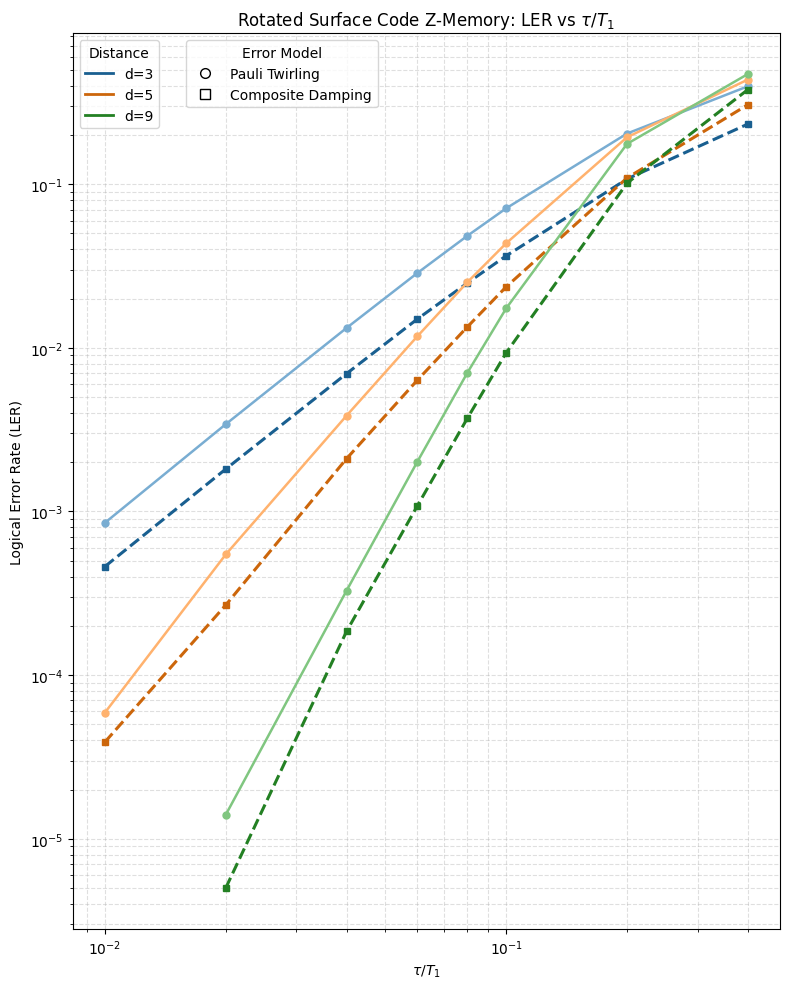

In [ ]:
# ...existing code...
# --- Plotting Results ---
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import colorsys

plt.figure(figsize=(8, 10))

x_vals = np.asarray(tau / T1, dtype=float)

# Helpers to lighten/darken base colors
import numpy as np

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')

# Plot paired curves per distance using related colors
color_handles = []  # for the distance legend (dark colors only)
for i, d in enumerate(DISTANCES):
    if d != 13:
        base = cmap(i % cmap.N)
        stim_color = lighten(base, 0.6)
        cpp_color = darken(base, 0.8)

        y_stim = np.asarray(stim_results[d], dtype=float)
        y_cpp  = np.asarray(cpp_results[d], dtype=float)

        mask_stim = y_stim > 0
        mask_cpp  = y_cpp  > 0

        plotted_any = False
        if mask_stim.any():
            plt.plot(
                x_vals[mask_stim], y_stim[mask_stim],
                marker='o', linestyle='-', linewidth=1.8, markersize=5,
                color=stim_color, label=f'Pauli Twirling d={d}'
            )
            plotted_any = True

        if mask_cpp.any():
            plt.plot(
                x_vals[mask_cpp], y_cpp[mask_cpp],
                marker='s', linestyle='--', linewidth=2.2, markersize=5,
                color=cpp_color, label=f'Composite Damping d={d}'
            )
            plotted_any = True

        # Add a single handle per distance using the dark color
        if plotted_any:
            color_handles.append(Line2D([0], [0], color=cpp_color, lw=2, label=f'd={d}'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Pauli Twirling'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Composite Damping'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model', loc='upper left', bbox_to_anchor=(.15, 1))

# Legend 2: colors for distance (dark colors only)
ax.add_artist(shape_legend)  # keep the first legend when adding the second
ax.legend(handles=color_handles, title='Distance', loc='upper left', ncol=1)

plt.tight_layout()
plt.savefig(f'figures/surfacecode_LER{SHOTS}.pdf', dpi=500, bbox_inches='tight')
plt.show()

Loading: surface_results/surfacecode_LER_13_shots1000_20250908-142032.json


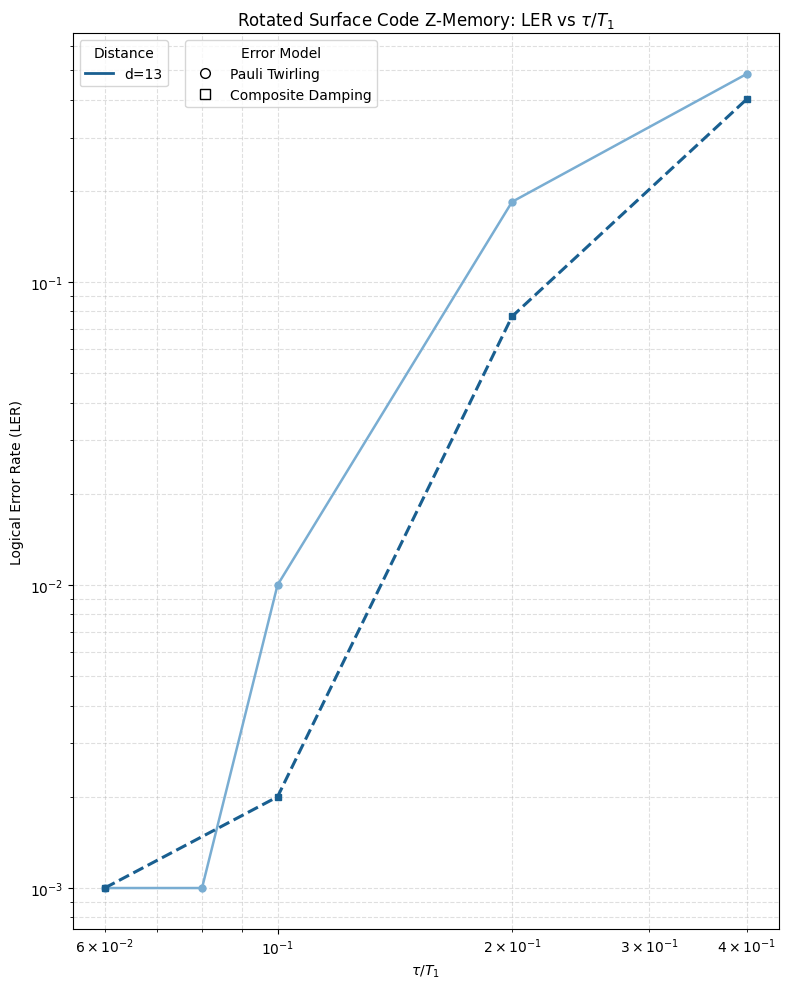

In [ ]:
# Regenerate plot from saved JSON results
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from pathlib import Path

# Set to the path printed by the save cell (or pick latest)
results_dir = Path("surface_results")
# results_file = results_dir / "surfacecode_LER_13_shots10000_YYYYMMDD-HHMMSS.json"
# Auto-pick latest matching file if desired:
candidates = sorted(results_dir.glob("surfacecode_LER_*_shots*.json"))
if not candidates:
    raise FileNotFoundError("No saved results found in ./results")
results_file = candidates[-1]
print(f"Loading: {results_file}")

with open(results_file, "r") as f:
    data = json.load(f)

SHOTS = int(data["shots"])
T1 = float(data["T1"])
T2 = float(data["T2"])
tau = np.asarray(data["tau"], dtype=float)
DISTANCES = np.asarray(data["distances"], dtype=int)
stim_results = {int(k): np.asarray(v, dtype=float) for k, v in data["stim"].items()}
cpp_results  = {int(k): np.asarray(v, dtype=float) for k, v in data["cpp"].items()}

plt.figure(figsize=(8, 10))
x_vals = np.asarray(tau / T1, dtype=float)

def lighten(color, factor=0.6):
    c = np.array(mcolors.to_rgb(color))
    return tuple(1 - (1 - c) * factor)

def darken(color, factor=0.8):
    c = np.array(mcolors.to_rgb(color))
    return tuple(c * factor)

cmap = plt.get_cmap('tab10')
color_handles = []

for i, d in enumerate(sorted(stim_results.keys())):
    base = cmap(i % cmap.N)
    stim_color = lighten(base, 0.6)
    cpp_color  = darken(base, 0.8)

    y_stim = np.asarray(stim_results[d], dtype=float)
    y_cpp  = np.asarray(cpp_results.get(d, np.zeros_like(y_stim)), dtype=float)

    mask_stim = y_stim > 0
    mask_cpp  = y_cpp  > 0

    plotted_any = False
    if mask_stim.any():
        plt.plot(
            x_vals[mask_stim], y_stim[mask_stim],
            marker='o', linestyle='-', linewidth=1.8, markersize=5,
            color=stim_color, label=f'Pauli Twirling d={d}'
        )
        plotted_any = True

    if mask_cpp.any():
        plt.plot(
            x_vals[mask_cpp], y_cpp[mask_cpp],
            marker='s', linestyle='--', linewidth=2.2, markersize=5,
            color=cpp_color, label=f'Composite Damping d={d}'
        )
        plotted_any = True

    if plotted_any:
        color_handles.append(Line2D([0], [0], color=cpp_color, lw=2, label=f'd={d}'))

plt.xlabel(r"$\tau / T_1$")
plt.ylabel("Logical Error Rate (LER)")
plt.title(r"Rotated Surface Code Z-Memory: LER vs $\tau/T_1$")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)

ax = plt.gca()

# Legend 1: marker shapes (black & white)
shape_handles = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Pauli Twirling'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           color='black', markersize=7, label='Composite Damping'),
]
shape_legend = ax.legend(handles=shape_handles, title='Error Model',
                         loc='upper left', bbox_to_anchor=(.15, 1))
ax.add_artist(shape_legend)

# Legend 2: distance colors (dark only)
if color_handles:
    ax.legend(handles=color_handles, title='Distance', loc='upper left', ncol=1)

# Save figure
Path("figures").mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(f'figures/surfacecode_LER{SHOTS}_from_saved.pdf', dpi=500, bbox_inches='tight')
plt.show()